In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sshikamaru/car-object-detection
!unzip car-object-detection.zip

Saving kaggle.json to kaggle.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 92% 103M/112M [00:04<00:00, 25.0MB/s] 
100% 112M/112M [00:05<00:00, 23.1MB/s]
Archive:  car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg

In [2]:
import pandas as pd

df = pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')
df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
df


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281,187,327,223
1,vid_4_10000.jpg,15,187,120,236
2,vid_4_10040.jpg,239,176,361,236
3,vid_4_10020.jpg,496,172,630,231
4,vid_4_10060.jpg,16,186,132,238
...,...,...,...,...,...
554,vid_4_9860.jpg,0,198,49,236
555,vid_4_9880.jpg,329,156,536,250
556,vid_4_9900.jpg,0,168,141,239
557,vid_4_9960.jpg,487,172,616,228


In [3]:
import torch
from torchvision import transforms
from PIL import Image

def get_tensor_image_from_path(path):
    img = Image.open(path).resize((256, 256))
    convert_tensor = transforms.ToTensor()
    return convert_tensor(img)


Image Shape: (380, 676, 3)


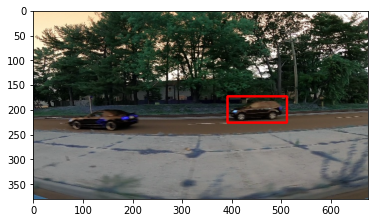

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import glob 
import random 

DIR = '/content/data/training_images/'
row = dict(df.iloc[103])
img = cv2.imread(DIR + row['image'])
print('Image Shape:', img.shape)
xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
plt.imshow(img)


In [5]:
def convert_tensor_and_frame(position, DIR = '/content/data/training_images/'):
    row = dict(df.iloc[position])
    img = cv2.imread(DIR + row['image'])
    #print('Image Shape:', img.shape)
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    tensor_image = get_tensor_image_from_path(DIR + row['image'])

    xmin *= (tensor_image.shape[1] / img.shape[1])
    xmax *= (tensor_image.shape[1] / img.shape[1])
    ymin *= (tensor_image.shape[2] / img.shape[0])
    ymax *= (tensor_image.shape[2] / img.shape[0])

    return tensor_image, xmin, xmax, ymin, ymax
    #cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
    #plt.imshow(img)


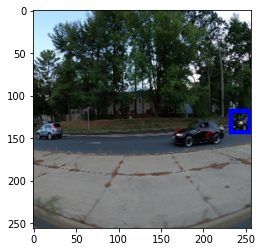

In [6]:
from torchvision.utils import draw_bounding_boxes
import torchvision
tensor_image, xmin, xmax, ymin, ymax = convert_tensor_and_frame(100)


boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=int)
colors = ["blue"]
int_tensor = (255 * tensor_image).type(torch.LongTensor)
int_tensor = torchvision.transforms.ConvertImageDtype(torch.uint8)(tensor_image)

result = draw_bounding_boxes(int_tensor, boxes, colors=colors, width=5)
plt.imshow(result.permute(1,2,0));


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda', index=0)

In [8]:
from torch.utils.data import Dataset, DataLoader

def SQuare(xmin, xmax, ymin, ymax):
    return (ymax - ymin) * (xmax - xmin)

def IoUfloat(xmin, xmax, ymin, ymax, Xmin, Xmax, Ymin, Ymax):
    x_in_min = max(xmin, Xmin)
    x_in_max = min(xmax, Xmax)
    y_in_min = max(ymin, Ymin)
    y_in_max = min(ymax, Ymax)

    intersection_square = SQuare(x_in_min, x_in_max, y_in_min, y_in_max)
    union_square = SQuare(xmin, xmax, ymin, ymax) +  SQuare(Xmin, Xmax, Ymin, Ymax) - intersection_square

    return intersection_square / union_square


class ImageDetectionDataset(Dataset):
    def __init__(self, df, DIR, delta = 2):
        self.df = df
        self.DIR = DIR
        self.augmented_list = [] # (path, xcenter, ycenter, w, h, confidence)
        self.masks = []
        for data_pos in range(self.df.shape[0]):
            for position in range(4):
                for i in range(-delta, delta):
                    image_path = self.DIR + df['image'].iloc[data_pos]
                    frame = [df['xmin'].iloc[data_pos], df['xmax'].iloc[data_pos], df['ymin'].iloc[data_pos], df['ymax'].iloc[data_pos]]
                    frame[position] += i
                    confidence = IoUfloat(df['xmin'].iloc[data_pos], df['xmax'].iloc[data_pos], df['ymin'].iloc[data_pos], df['ymax'].iloc[data_pos],
                                     frame[0], frame[1], frame[2], frame[3]) 
                    x_center = (frame[0] + frame[1]) / 2
                    y_center = (frame[2] + frame[3]) / 2 
                    w = frame[1] - frame[0]
                    h = frame[3] - frame[2]

                    x_center *= (256 / 676)
                    w *= (256 / 676)
                    y_center *= (256 / 380)
                    h *= (256 / 380)

                    self.augmented_list.append((image_path, confidence, x_center, y_center, w, h))


    def __len__(self):
        return len(self.augmented_list)

    def __getitem__(self, position):
        image_tensor = get_tensor_image_from_path(self.augmented_list[position][0]).to(device)
        target_tensor = torch.FloatTensor([self.augmented_list[position][1], 
                                           self.augmented_list[position][2],
                                           self.augmented_list[position][3],
                                           self.augmented_list[position][4],
                                           self.augmented_list[position][5]]).to(device)
        
        return {'X' : image_tensor, 'y': target_tensor}


In [9]:
dataset = ImageDetectionDataset(df, '/content/data/training_images/', 5)
dataset[0]['X'].shape, dataset[0]['y'].shape


(torch.Size([3, 256, 256]), torch.Size([5]))

In [10]:
dataset.augmented_list

[('/content/data/training_images/vid_4_1000.jpg',
  0.9019607843137255,
  114.1775147928994,
  138.10526315789474,
  19.31360946745562,
  24.25263157894737),
 ('/content/data/training_images/vid_4_1000.jpg',
  0.92,
  114.36686390532545,
  138.10526315789474,
  18.93491124260355,
  24.25263157894737),
 ('/content/data/training_images/vid_4_1000.jpg',
  0.9387755102040817,
  114.55621301775147,
  138.10526315789474,
  18.556213017751478,
  24.25263157894737),
 ('/content/data/training_images/vid_4_1000.jpg',
  0.9583333333333334,
  114.74556213017752,
  138.10526315789474,
  18.17751479289941,
  24.25263157894737),
 ('/content/data/training_images/vid_4_1000.jpg',
  0.9787234042553191,
  114.93491124260355,
  138.10526315789474,
  17.798816568047336,
  24.25263157894737),
 ('/content/data/training_images/vid_4_1000.jpg',
  1.0,
  115.12426035502958,
  138.10526315789474,
  17.420118343195266,
  24.25263157894737),
 ('/content/data/training_images/vid_4_1000.jpg',
  0.9782608695652174,
 

In [11]:
train_loader = DataLoader(dataset, batch_size = 50)


In [12]:
import torch.nn as nn
import torchvision.transforms as transforms

class DETR(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
        )
        self.transformer = nn.Transformer(batch_first=True)
        self.positional_encoding = nn.Parameter(torch.randn(8, 512))
        self.bboxes = nn.Parameter(torch.randn(20, 512))
        self.fc = nn.Sequential(nn.Linear(512, 32),
                                nn.ReLU(),
                                nn.Linear(32, 5))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        batch_size = input.shape[0] 
        hidden = self.cnn(input)
        hidden = hidden.reshape((-1, 8, 512))
        hidden += self.positional_encoding
        bboxes_batches = torch.cat([self.bboxes.unsqueeze(0)] * batch_size, 0)
        bboxes_after_transformer = self.transformer(hidden, bboxes_batches)
        final_boxes = self.fc(bboxes_after_transformer)
        final_boxes[:, :, 0] = self.sigmoid(final_boxes[:, :, 0])
        return final_boxes



In [13]:
def SQuare(xmin, xmax, ymin, ymax):
    return (ymax - ymin) * (xmax - xmin)

def IoU(xmin, xmax, ymin, ymax, Xmin, Xmax, Ymin, Ymax):
    x_in_min = torch.maximum(xmin, Xmin)
    x_in_max = torch.minimum(xmax, Xmax)
    y_in_min = torch.maximum(ymin, Ymin)
    y_in_max = torch.minimum(ymax, Ymax)

    intersection_square = SQuare(x_in_min, x_in_max, y_in_min, y_in_max)
    union_square = SQuare(xmin, xmax, ymin, ymax) +  SQuare(Xmin, Xmax, Ymin, Ymax) - intersection_square

    return intersection_square / union_square

def IoUTensors(a: torch.tensor, b: torch.tensor) -> torch.tensor:
    xmin = a[0] - a[2] / 2
    xmax = a[0] + a[2] / 2
    ymin = a[1] - a[3] / 2
    ymax = a[1] + a[3] / 2

    Xmin = b[0] - b[2] / 2
    Xmax = b[0] + b[2] / 2
    Ymin = b[1] - b[3] / 2
    Ymax = b[1] + b[3] / 2
    return IoU(xmin, xmax, ymin, ymax, Xmin, Xmax, Ymin, Ymax)

criterion = nn.MSELoss()

def single_dim_hungarian_loss(input: torch.tensor, target: torch.tensor, l1: float = 1, l2: float = 2) -> torch.tensor:
    answer = l2 * criterion(input[:,0,1:], target[:, 1:])
    for i in range(input.shape[1]):
        answer = torch.minimum(answer, l2 * criterion(input[:,i,1:], target[:,1:]))
    return answer

In [14]:
model = DETR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion_confidence = single_dim_hungarian_loss

In [15]:
from tqdm.auto import tqdm 

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
    sum_loss, cnt_loss = 0, 0
    cnt_ok = 1000
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(batch['X'])
        loss = criterion(output, torch.cat([batch['y'].unsqueeze(1)] * 20, 1))
        sum_loss += loss.item()
        cnt_loss += 1
        if cnt_loss % 20  == 0:
            print(sum_loss / cnt_loss)
            sum_loss, cnt_loss = 0, 0

        loss.backward()
        optimizer.step()
        cnt_ok -= 1
        if cnt_ok == 0:
            break

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

7427.4861328125
9603.7791015625
6957.643115234375
7151.44033203125
7732.503771972656
7538.3513671875
6973.935559082031
7611.907189941407
6246.6585693359375
6280.017004394531
5950.267419433594
5493.656335449219
6293.649816894531
4041.4829223632814
4181.903088378906
4414.262463378906
4208.797064208984
3542.5295959472655
3873.50166015625
2854.1650451660157
2977.376354980469
2562.445233154297


  0%|          | 0/448 [00:00<?, ?it/s]

2395.4155883789062
3302.3834899902345
1934.8215698242188
2018.6987518310548
2267.707388305664
1965.823095703125
1912.3208374023438
1962.8781372070312
1670.649237060547
1751.2251373291015
1668.1746063232422
1617.1189727783203
1696.381527709961
1269.8981521606445
1312.6416244506836
1504.4473068237305
1347.1599227905274
1426.826570892334
1545.441983795166
1505.9946815490723
1539.8541290283204
1123.449607849121


  0%|          | 0/448 [00:00<?, ?it/s]

1234.7520568847656
1582.2897521972657
1107.123649597168
1271.739699935913
1469.2824340820312
1237.5616788864136
1383.599624633789
1353.725440979004
1278.301710510254
1411.641534423828
1410.7551986694336
1412.0249771118165
1379.1897537231446
1194.3623962402344
1136.463716506958
1387.7560974121093
1260.5930442810059
1376.3409065246583
1489.0800491333007
1484.0594230651855
1509.0677505493163
1097.6023818969727


  0%|          | 0/448 [00:00<?, ?it/s]

1207.5957092285157
1570.0556060791016
1091.5840896606446
1264.6859424591064
1464.9853019714355
1225.5638982772828
1373.471206665039
1350.8757293701171
1275.2990653991699
1408.8692443847656
1406.3757568359374
1406.5183242797852
1393.6540420532226
1193.2193885803222
1121.4643989562987
1386.418310546875
1266.133585357666
1371.3239540100099
1484.1842979431153
1473.3311317443847
1500.9861892700196
1094.7905834197998


  0%|          | 0/448 [00:00<?, ?it/s]

1203.0272155761718
1586.1897560119628
1081.8995300292968
1261.3913272857667
1463.9654106140138
1227.2871578216552
1370.6822814941406
1356.6291915893555
1275.098723602295
1409.3002853393555
1405.2022659301758
1404.3671081542968
1403.2751861572265
1190.3096160888672
1119.1589252471924
1383.7315406799316
1268.5584465026855
1368.1599296569825
1484.2608642578125
1469.6842956542969
1500.530177307129
1093.1759510040283


  0%|          | 0/448 [00:00<?, ?it/s]

1201.6766571044923
1592.6387966156005
1078.9285202026367
1262.0851749420167
1462.0920768737792
1228.603170967102
1370.0695434570312
1359.418881225586
1274.6851196289062
1409.277247619629
1404.8271255493164
1403.6821044921876
1406.6598388671875
1189.2188285827638
1118.9026695251464
1383.6278038024902
1268.6315727233887
1367.496572113037
1484.4799461364746
1469.0626167297364
1500.9508155822755
1092.4947887420653


  0%|          | 0/448 [00:00<?, ?it/s]

1201.2984954833985
1594.794005203247
1077.897479248047
1262.0587516784667
1461.8827743530273
1229.0343179702759
1369.7369567871094
1360.627145385742
1274.7032249450683
1409.3152435302734
1404.5472213745118
1403.410223388672
1407.968653869629
1188.7115432739258
1118.7372451782226
1383.4530960083007
1268.735659790039
1366.9552574157715
1484.5831825256348
1469.239828491211
1500.9216270446777
1092.4272274017335


  0%|          | 0/448 [00:00<?, ?it/s]

1201.0052856445313
1596.0079917907715
1077.461280822754
1262.5136005401612
1461.0933639526368
1229.3872606277466
1369.5805358886719
1361.5928924560546
1274.6930908203126
1409.460745239258
1404.5026947021483
1403.419174194336
1408.478303527832
1188.2388900756837
1118.7684200286865
1383.6093223571777
1268.4836196899414
1367.2710006713867
1484.507932281494
1469.2810913085937
1501.1213760375977
1092.159369277954


  0%|          | 0/448 [00:00<?, ?it/s]

1200.8522018432618
1596.6426403045655
1077.2422134399415
1262.111169052124
1461.5815956115723
1229.3992778778077
1369.444076538086
1361.691017150879
1274.6697631835937
1409.510968017578
1404.6908233642578
1403.3678817749023
1408.6152297973633
1188.3442001342773
1118.7454277038573
1383.1524589538574
1268.2935066223145
1367.3197624206543
1484.5375602722168
1469.4344261169433
1501.0612129211427
1092.2705249786377


  0%|          | 0/448 [00:00<?, ?it/s]

1200.6336791992187
1597.2219802856446
1077.043685913086
1261.6699104309082
1462.0575996398925


KeyboardInterrupt: ignored

In [16]:
def inference(path, lim = 0.0): 
    image_tensor = get_tensor_image_from_path(path).to(device).unsqueeze(0)
    output = model(image_tensor)# 1, 20, 5
    for i in range(20):
        confidence = output[0,i,0].item()
        print(confidence)
        if confidence > lim:
            x_center, y_center, w, h = output[0,i,1].item(), output[0,i,2].item(), output[0,i,3].item(), output[0,i,4].item()
            yield ( x_center, y_center, w, h)


0.9637907147407532
118.0261459350586 140.6742706298828 38.75908279418945 32.890235900878906
0.9625544548034668
117.95637512207031 140.63609313964844 38.78721618652344 32.874359130859375
0.9644860625267029
118.4391098022461 141.15667724609375 38.816532135009766 32.90791702270508
0.9641838669776917
118.31822204589844 140.9752655029297 38.665740966796875 32.92903518676758
0.9617659449577332
118.30701446533203 140.81907653808594 38.73313903808594 32.91220474243164
0.9655035734176636
118.54979705810547 141.4324188232422 38.937530517578125 32.996376037597656
0.9675883650779724
118.04821014404297 140.5125732421875 38.581974029541016 32.98258972167969
0.964857280254364
118.42057800292969 141.0144500732422 39.055423736572266 32.95587921142578
0.9632662534713745
118.32229614257812 140.90011596679688 38.754051208496094 32.94749069213867
0.9643896222114563
118.4338607788086 141.05093383789062 38.85387420654297 32.966365814208984
0.9612784385681152
118.43667602539062 141.12022399902344 38.845668792

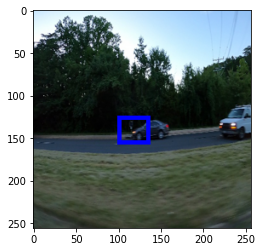

In [18]:
from torchvision.utils import draw_bounding_boxes
import torchvision

path = '/content/data/testing_images/vid_5_26700.jpg'
for  x_center, y_center, w, h in inference(path):
    tensor_image =  get_tensor_image_from_path(path).to(device)

    print( x_center, y_center, w, h)
    boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=int)
    colors = ["blue"]
    int_tensor = (255 * tensor_image).type(torch.LongTensor)
    int_tensor = torchvision.transforms.ConvertImageDtype(torch.uint8)(tensor_image)

    result = draw_bounding_boxes(int_tensor, boxes, colors=colors, width=5)
    plt.imshow(result.permute(1,2,0));
